在cuda:0上训练
Epoch:1, 训练损失:0.946, 训练准确率:0.648, 测试准确率:0.837
Epoch:2, 训练损失:0.406, 训练准确率:0.852, 测试准确率:0.873
Epoch:3, 训练损失:0.330, 训练准确率:0.879, 测试准确率:0.855
Epoch:4, 训练损失:0.290, 训练准确率:0.893, 测试准确率:0.884
Epoch:5, 训练损失:0.265, 训练准确率:0.902, 测试准确率:0.902
训练结束。损失: 0.265, 训练准确率: 0.902, 测试准确率: 0.902
837.8 样本/秒 在 cuda:0


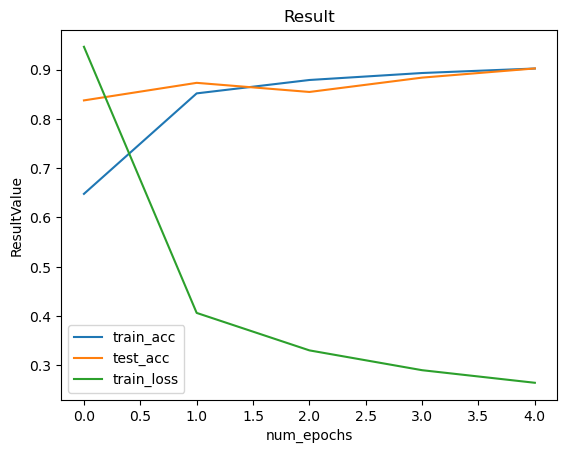

/home/lindenbaum/Documents/Python/DeepLearning/DeepLearning/CNN/st_train.py:230: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(1, n, figsize=(8, 8))


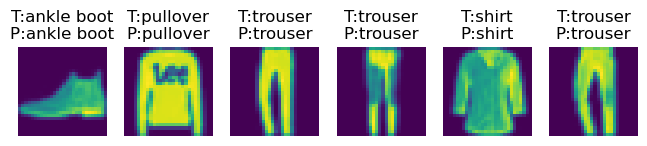

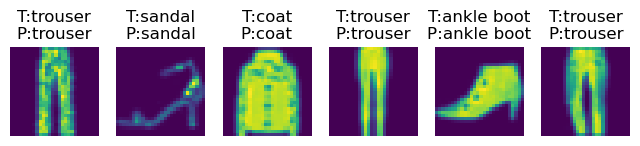

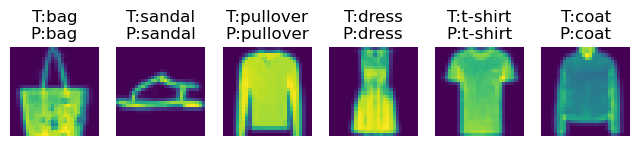

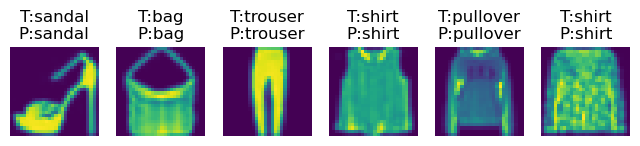

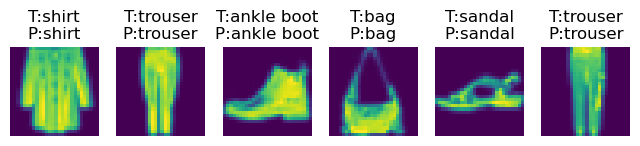

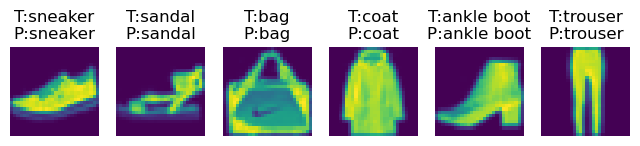

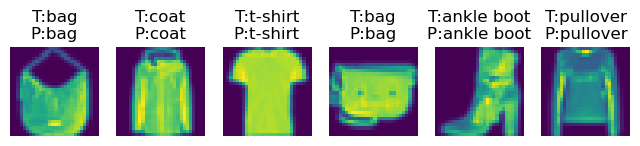

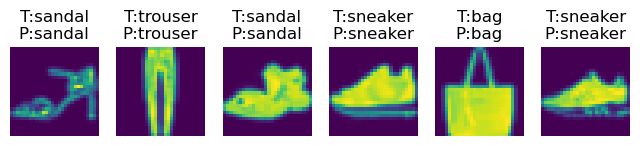

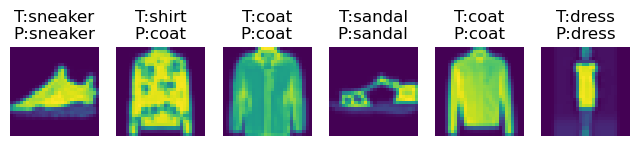

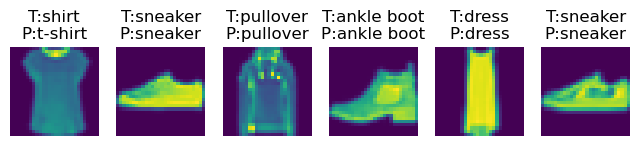

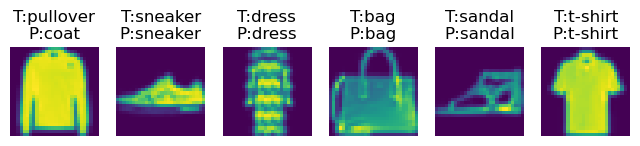

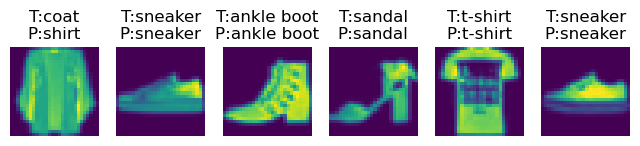

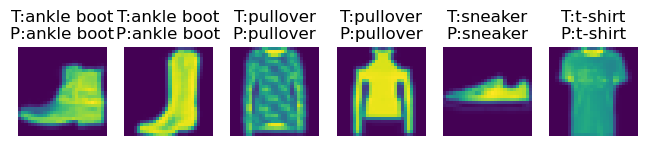

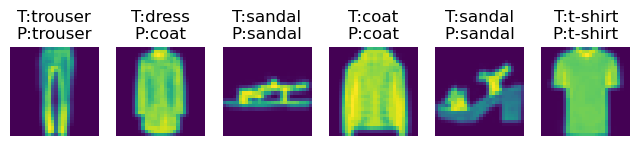

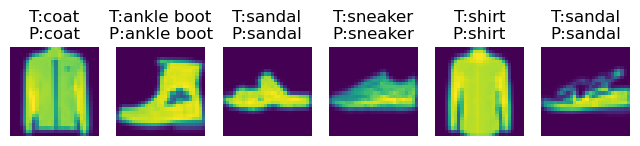

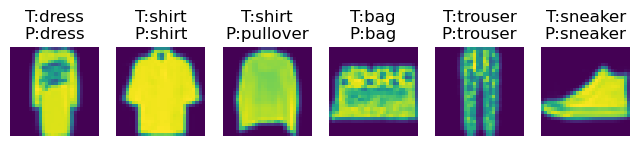

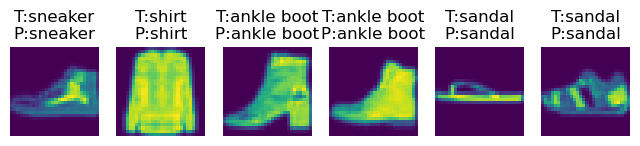

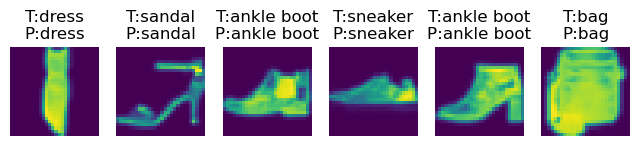

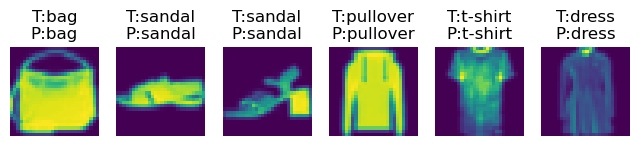

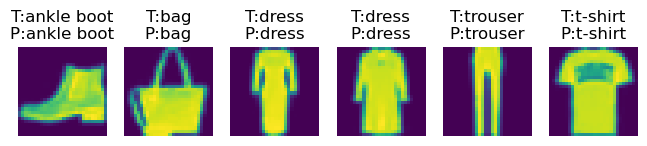

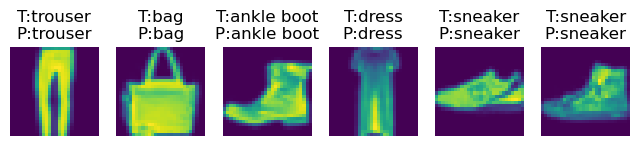

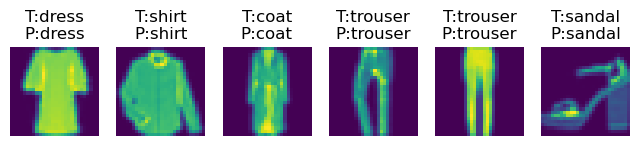

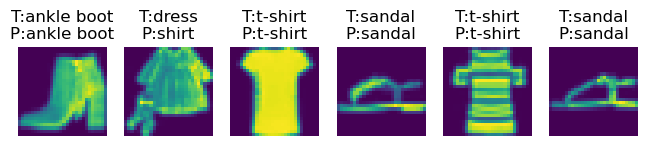

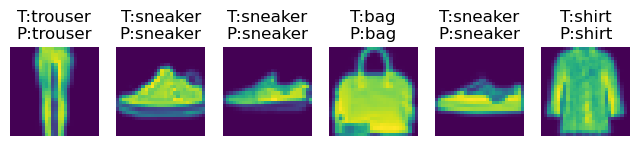

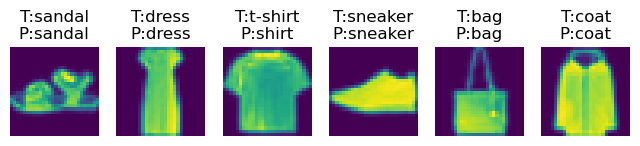

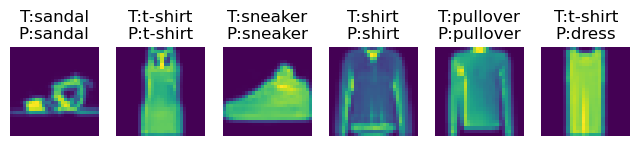

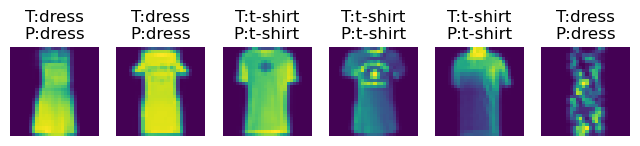

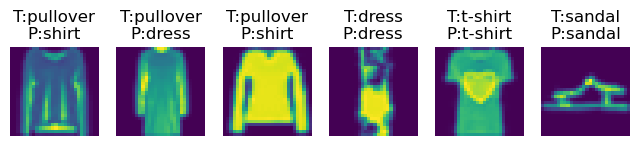

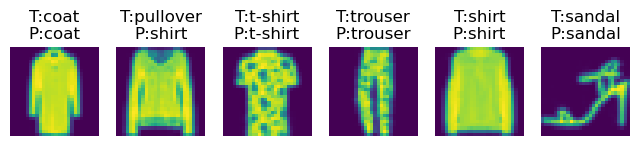

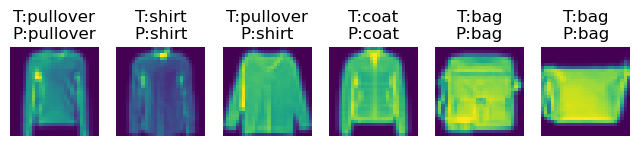

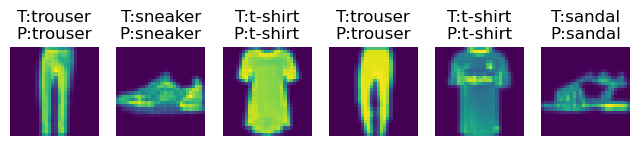

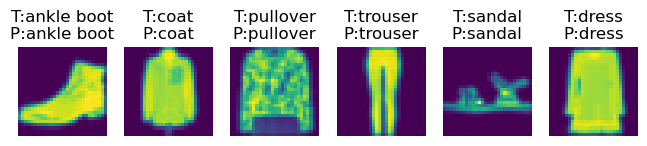

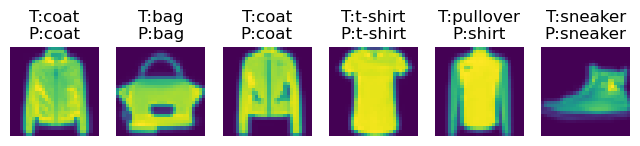

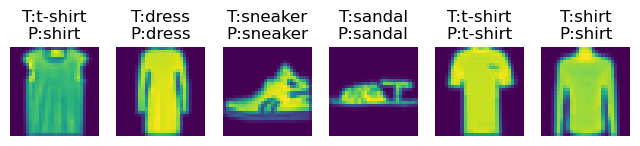

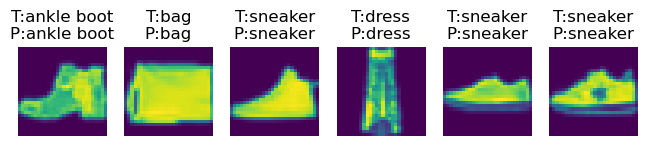

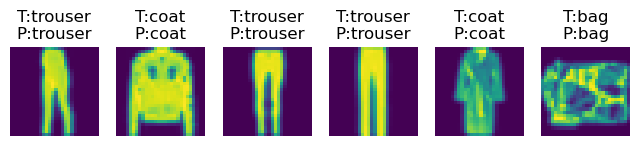

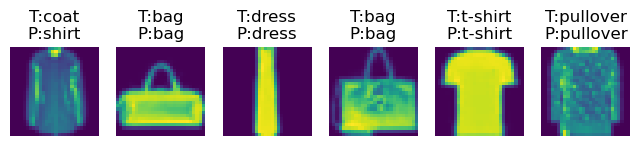

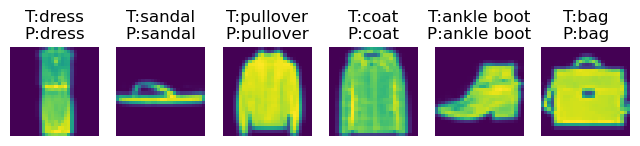

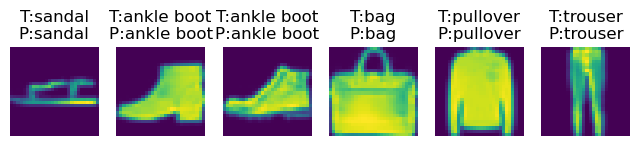

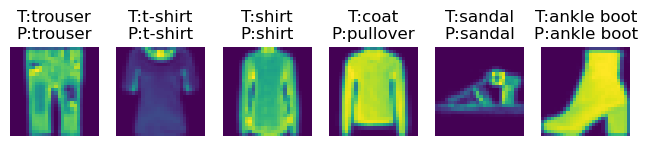

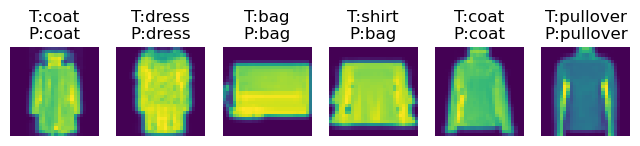

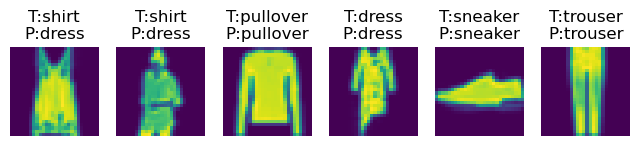

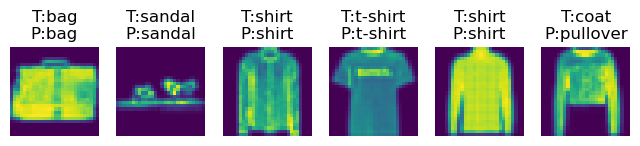

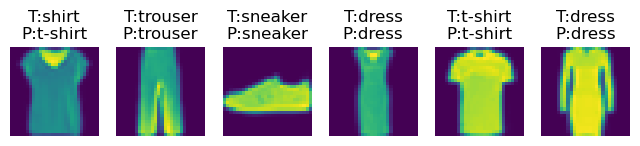

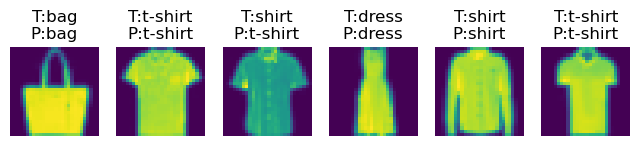

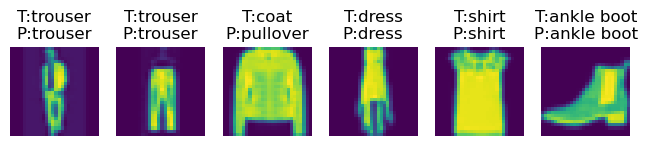

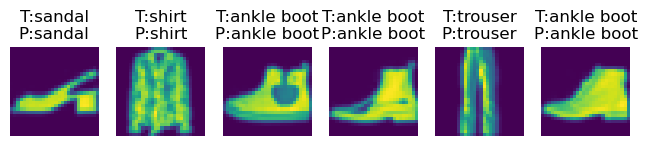

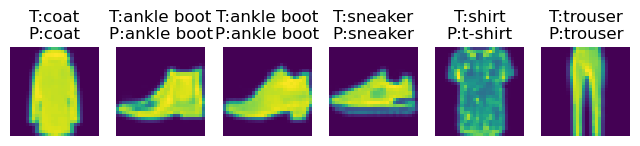

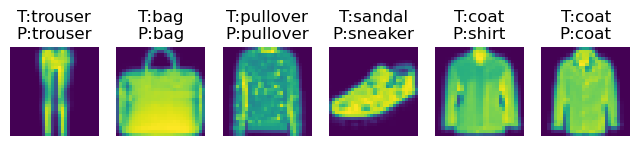

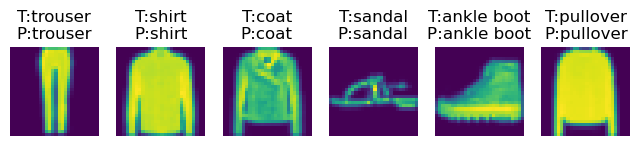

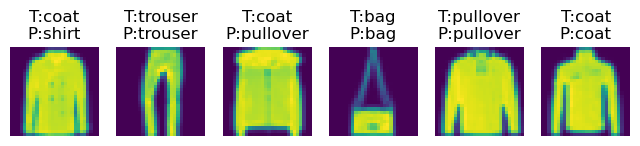

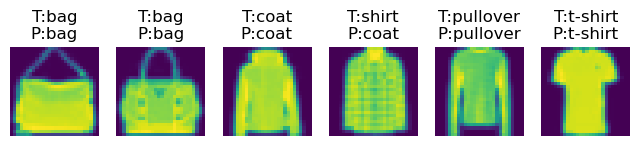

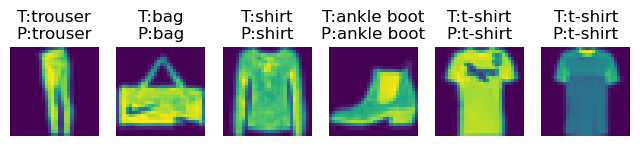

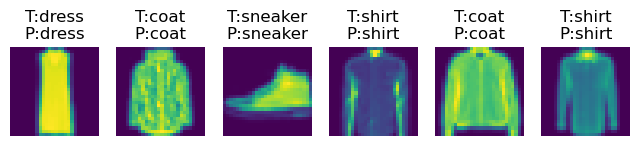

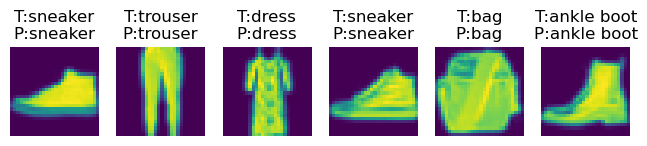

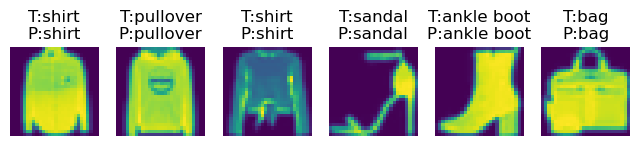

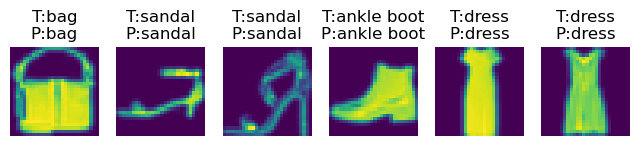

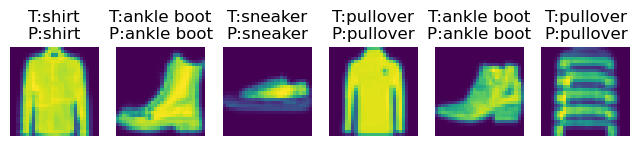

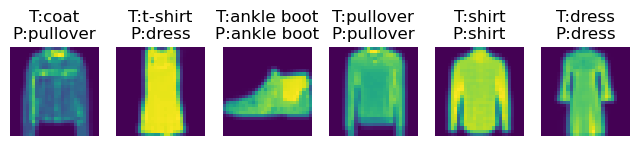

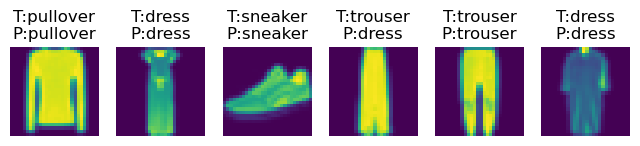

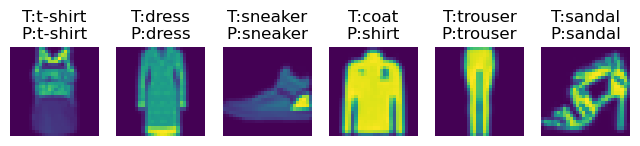

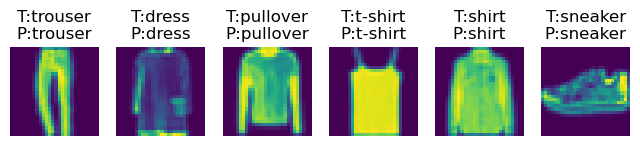

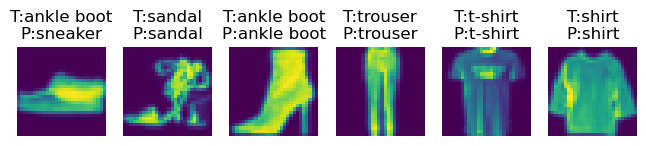

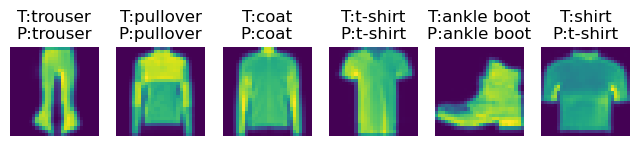

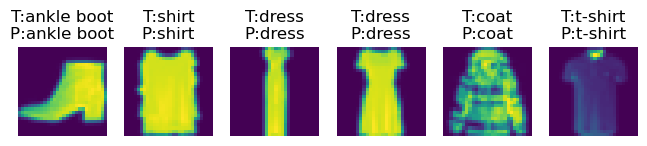

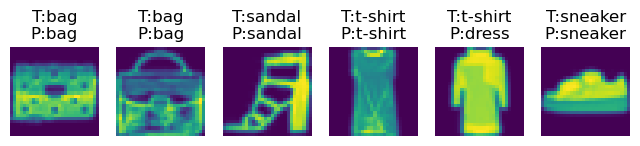

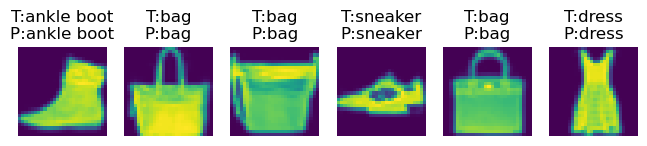

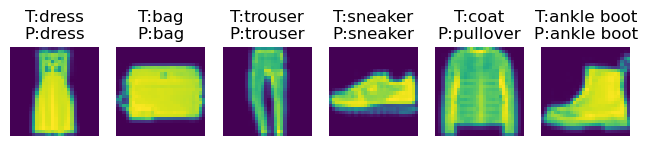

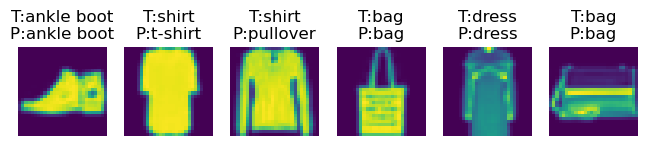

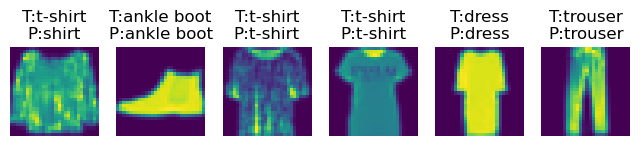

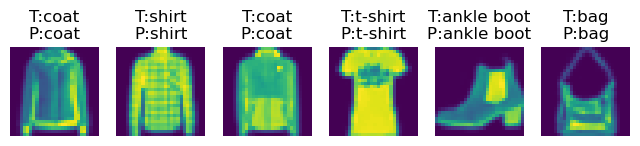

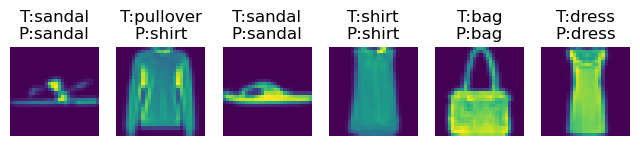

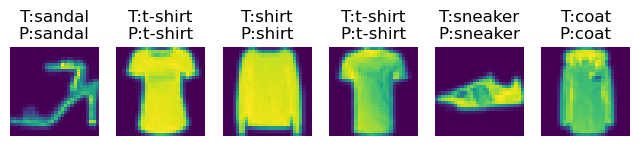

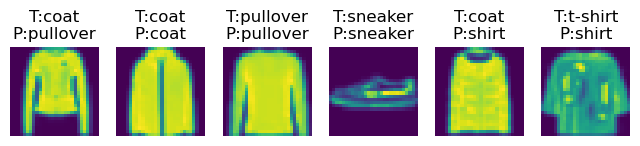

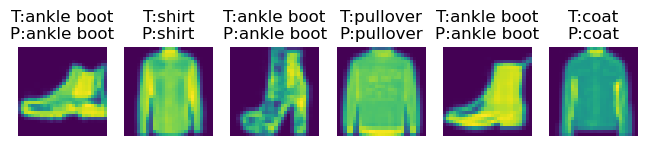

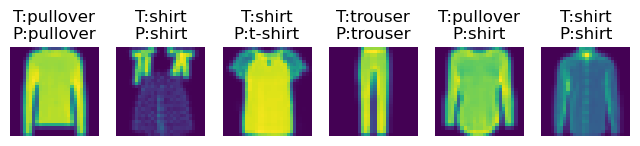

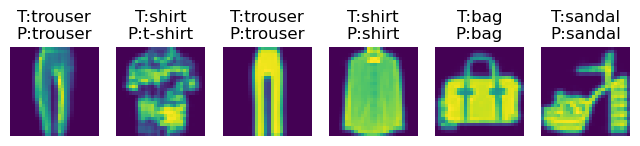

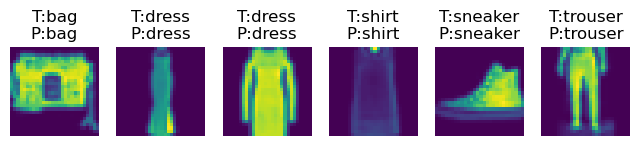

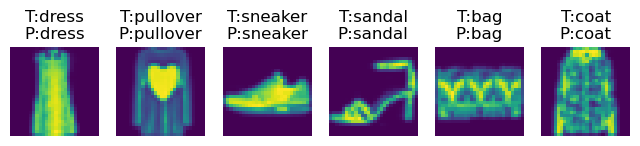

In [1]:
import torchvision
import st_train
from torch import nn
from torch.utils import data
"""
VGG使用可复用的卷积块构造网络。不同的VGG模型可通过每个块中卷积层数量和输出通道数量的差异来定义。
块的使用导致网络定义的非常简洁。使用块可以有效地设计复杂的网络。
深层且窄的卷积(即3*3)比较浅层且宽的卷积更有效。
"""
# VGGNet是使用块的现代卷积神经网络,每个块中有若干个卷积层,最后池化
def vgg_blocks(in_channels, out_channels, num_convs): # num_convs表示一个块中有多少个卷积层
    layers = []
    for _ in range(num_convs): # 循环添加卷积层
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

def vgg(conv_arch): # conv_arch是一个超参数 该变量指定了每个VGG块里卷积层个数和输出通道数
    conv_blocks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch: # 卷积层部分
        conv_blocks.append(vgg_blocks(in_channels, out_channels, num_convs))
        in_channels = out_channels
    return nn.Sequential(
        *conv_blocks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels*7*7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
learning_rate, num_epochs, batch_size = 0.05, 5, 128
ratio = 4 # 原始网络训练量大,以此来减小输出通道数
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
VGGnet = vgg(small_conv_arch)
train_iter, test_iter = st_train.load_MINST_data(batch_size, resize=(224,224))
result = st_train.ResVisualization(('train_acc','test_acc','train_loss'), num_epochs)
st_train.train_gpu(VGGnet, train_iter, test_iter, num_epochs, learning_rate, st_train.try_gpu(), result)
result.plot_res()
st_train.std_prediction_gpu(VGGnet, test_iter, device=st_train.try_gpu(), resized=True)